In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150.

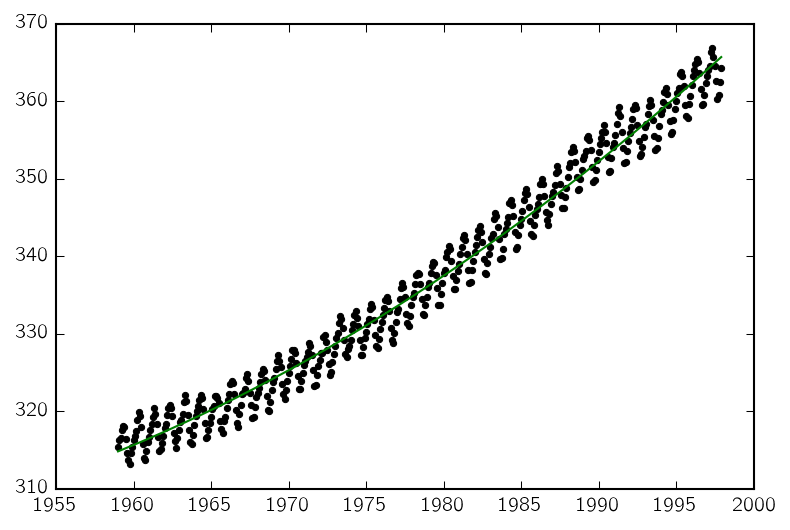

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as pl

data = sm.datasets.get_rdataset("co2").data
t = np.array(data.time)
y = np.array(data.co2)

A = np.vander(t, 3)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y))
mu = np.dot(A, w)

pl.plot(t, y, ".k")
pl.plot(t, mu, "g");

In [3]:
from genrp import GP

In [4]:
gp = GP()
gp.add_term(np.var(y), 0.0)
gp.add_term(np.var(y), 5.0)
gp.add_term(np.var(y), 1.0)
# gp.add_term(np.var(y), 1.0)
gp.add_term(np.var(y), 2.0, 0.0)
gp.add_term(np.var(y), 1.0, 0.0)
gp.add_term(np.var(y), 1.0, 0.0)
gp.add_term(np.var(y), 1.0, 0.0)

In [5]:
gp.compute(t, 0.1 + np.zeros_like(t))
gp.log_likelihood(y - mu)

-54789.79685745355

In [6]:
from scipy.optimize import minimize

def nll(theta):
    gp.params = theta[1:]
    gp.compute(t, np.exp(theta[0]) + np.zeros_like(t))
    ll = gp.log_likelihood(y - mu)
    if not np.isfinite(ll):
        return 1e10
    return -ll

def min_nll(p):
    p = np.append(np.log(np.median(np.abs(np.diff(y)))), p)
    result = minimize(nll, p, method="L-BFGS-B", bounds=[(-30, 30) for _ in range(len(p))])
    print(result.status, result.fun, result.x)
    return result

In [34]:
results = list(map(
    min_nll, np.random.uniform(-1, 1, (10, len(gp.params)))
))
i = np.argmin([r.fun for r in results])
result = results[i]

0 117.12839904168976 [ -1.58976999e+00  -4.09321651e+00  -4.04909651e+00  -5.00488593e+00
  -4.47306571e+00  -1.78404033e+00  -2.81852852e+00  -8.20580852e+00
  -8.34824666e+00   1.72913045e+00   5.40644176e+00  -1.02242792e+01
   6.93343265e-01   8.21265663e+00  -1.03996387e+01   5.43592793e-04
  -6.28792781e+00  -6.10545107e+00   2.50763628e+00]
0 434.07582802297316 [ -7.88701054e+00  -3.63332897e+00  -3.63183447e+00  -1.25261134e+00
  -3.48069465e+00  -5.94197985e+00  -5.77112053e+00  -5.86560035e+00
  -5.73470760e+00  -1.15076412e+00  -4.10395520e+00  -4.54816740e+00
  -2.24970564e+00  -4.99085703e+00  -5.12115392e+00   3.75519631e-04
   7.46441260e-01  -2.97237730e+00   2.56774404e+00]
0 433.26974979035003 [-20.69221445  -7.1534784  -18.02409841  -1.29647998  -3.51626048
 -11.49420104 -12.09892626   0.78331299  -2.98788804   0.03551593
 -11.82095166  -9.74062822  -9.6489473    5.90910401 -12.69882838
  -2.26375332 -23.1238945  -22.61513512   5.86383566]
1 114.02725120264057 [ -1.5

In [35]:
result

      fun: 114.02725120264057
 hess_inv: <19x19 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.62476919e+00,   1.46985712e-01,   2.50247467e-01,
         3.55530005e+00,   6.67156144e+00,   1.30890498e-01,
         2.30852493e-01,   1.03389652e-01,   6.79889922e-01,
        -3.36487176e+00,  -5.38011591e-01,  -3.01440650e-01,
         1.24151171e+01,  -4.41997372e-01,  -4.74483386e-01,
         4.85705755e+01,  -3.05732328e-02,  -3.09199777e-02,
         3.77478102e+00])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15020
      nit: 625
   status: 1
  success: False
        x: array([ -1.56492689e+00,  -4.24456151e+00,  -3.29525989e+00,
        -1.49629167e+00,  -3.04871109e+00,  -4.47307968e+00,
        -3.22903444e+00,  -1.82335407e+00,  -5.66468471e+00,
        -1.29118813e+00,   4.04876832e+00,  -9.46631319e+00,
         6.93339917e-01,   7.30153693e+00,  -9.95565191e+00,
         5.38844385e-04,  -5.25715384e+00,  -1.02604287e+01,
   

In [36]:
gp.params = result.x[1:]
gp.compute(t, np.exp(result.x[0]) + np.zeros_like(t))

In [37]:
K = gp.get_matrix(t)
K[np.diag_indices_from(K)] += np.exp(2 * result.x[0])
# x = np.linspace(max(t)-5, max(t)+25, 5000)
x = np.linspace(min(t), 2025, 5000)
Ks = gp.get_matrix(x, t)

In [38]:
B = np.vander(x, len(w))
mean_pred = np.dot(B, w)
pred = mean_pred + np.dot(Ks, np.linalg.solve(K, y - mu))
std = np.sqrt(np.diag(gp.get_matrix(x, x) - np.dot(Ks, np.linalg.solve(K, Ks.T))))

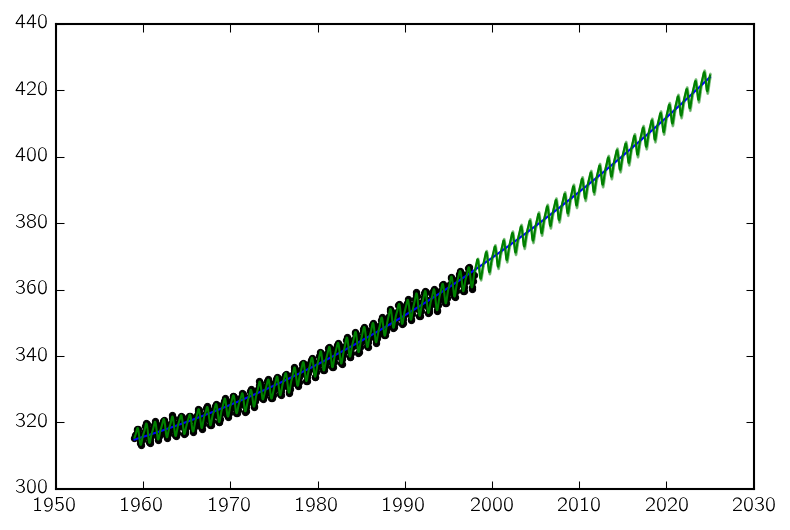

In [39]:
m = (t <= x.max()) * (t >= x.min())
pl.plot(t[m], y[m], ".k")
pl.plot(x, mean_pred, "b")
pl.fill_between(x, pred + std, pred - std, color="g", alpha=0.5)
pl.plot(x, pred, "g");

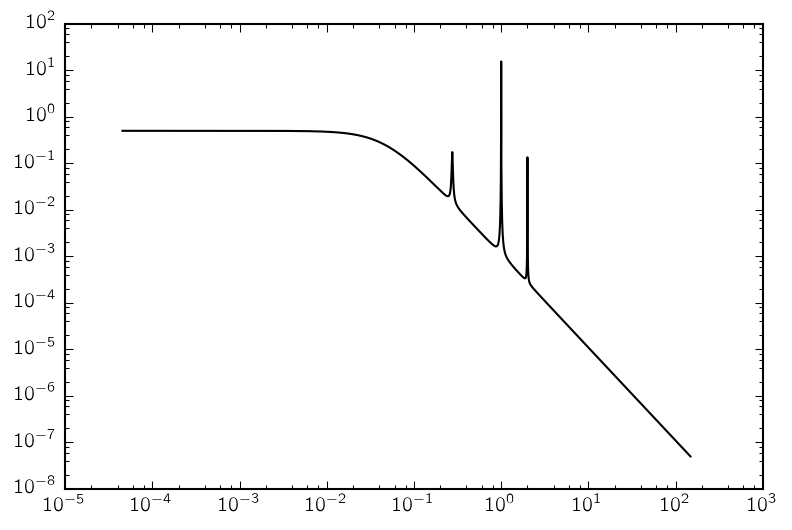

In [40]:
freq = np.exp(np.linspace(-10.0, 5.0, 5000))
power = gp.get_psd(freq)
pl.plot(freq, power, "k")
pl.xscale("log")
pl.yscale("log")